# Spatio-Temporal Timeseries Multi-step Forecasting

- EDA(X)
- Feature Engineering : 시계열 예측에서 feature는 예측 step에서도 있는 변수여야함, 시간에 대한 함수 or 시간에 따라 변하지 않는 것(X,Y coordinate)
- Outlier processing
- Model : ST-GCN
- Timeseries Split CV (To optimize hyperparameter)
- Direct and Recursive


참고 링크 :
- 유튜브 설명 (https://www.youtube.com/watch?v=R8s5Kh5eKm8)
- 소스 코드 (https://github.com/VeritasYin/STGCN_IJCAI-18)
- 소스 코드 (https://github.com/yysijie/st-gcn)

# 데이터 불러오기

In [73]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
census = pd.read_csv("census_starter.csv")

train["istest"] = 0
test["istest"] = 1

In [75]:
train.describe()

,cfips,microbusiness_density,active,istest
count,122265.000000,122265.000000,1.222650e+05,122265.0
mean,30376.037640,3.817671,6.442858e+03,0.0
std,15143.508721,4.991087,3.304001e+04,0.0
min,1001.000000,0.000000,0.000000e+00,0.0
25%,18177.000000,1.639344,1.450000e+02,0.0
50%,29173.000000,2.586543,4.880000e+02,0.0
75%,45077.000000,4.519231,2.124000e+03,0.0
max,56045.000000,284.340030,1.167744e+06,0.0


In [2]:
raw = pd.concat([train, test])
raw = raw.sort_values(by = ["cfips", "row_id"]).reset_index()

In [3]:
raw.cfips

0          1001
1          1001
2          1001
3          1001
4          1001
          ...  
147340    56045
147341    56045
147342    56045
147343    56045
147344    56045
Name: cfips, Length: 147345, dtype: int64

In [4]:
raw["dcount"] = raw.groupby("cfips")["row_id"].cumcount()

In [5]:
raw

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,dcount
0,0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,0
1,1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,1
2,2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2
3,3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,3
4,4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,4
...,...,...,...,...,...,...,...,...,...,...
147340,12539,56045_2023-02-01,56045,NaN,NaN,2023-02-01,NaN,NaN,1,42
147341,15674,56045_2023-03-01,56045,NaN,NaN,2023-03-01,NaN,NaN,1,43
147342,18809,56045_2023-04-01,56045,NaN,NaN,2023-04-01,NaN,NaN,1,44
147343,21944,56045_2023-05-01,56045,NaN,NaN,2023-05-01,NaN,NaN,1,45


In [6]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,0
...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,0
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,0
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,0
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,0


In [7]:
coordinate = pd.read_excel("us-county-boundaries.xlsx")

In [8]:
coordinate = coordinate.sort_values(by="GEOID").loc[coordinate["GEOID"]<=56045].reset_index()

In [9]:
coordinate

,index,Geo Point,Geo Shape,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,STUSAB,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,STATE_NAME,COUNTYFP NOZERO
0,748,"32.5349201866, -86.642749235","{""coordinates"":[[[-86.903096,32.540626],[-86.9...",1,1,161526,1001,Autauga,Autauga County,AL,...,388.0,33860.0,NaN,A,1539602137,25706961,32.532237,-86.646439,Alabama,1
1,638,"30.6609696648, -87.7498400784","{""coordinates"":[[[-87.990684,30.55549],[-87.99...",1,3,161527,1003,Baldwin,Baldwin County,AL,...,380.0,19300.0,NaN,A,4117621645,1132980868,30.659218,-87.746067,Alabama,3
2,772,"31.8696032448, -85.3931969755","{""coordinates"":[[[-85.429819,32.045983],[-85.4...",1,5,161528,1005,Barbour,Barbour County,AL,...,NaN,21640.0,NaN,A,2292160139,50523213,31.870253,-85.405103,Alabama,5
3,1395,"32.9986442965, -87.1264391014","{""coordinates"":[[[-87.312265,33.086219],[-87.3...",1,7,161529,1007,Bibb,Bibb County,AL,...,142.0,13820.0,NaN,A,1612167476,9602089,33.015893,-87.127148,Alabama,7
4,1876,"33.9808673856, -86.5673709608","{""coordinates"":[[[-86.749188,33.997596],[-86.7...",1,9,161530,1009,Blount,Blount County,AL,...,142.0,13820.0,NaN,A,1670103866,15015467,33.977357,-86.566440,Alabama,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,632,"41.6594961424, -108.879430782","{""coordinates"":[[[-109.49666,42.263319],[-109....",56,37,1609192,56037,Sweetwater,Sweetwater County,WY,...,NaN,40540.0,NaN,A,27005754251,166230252,41.660328,-108.875677,Wyoming,37
3138,2877,"43.9346374164, -110.589809669","{""coordinates"":[[[-111.049091,44.132368],[-111...",56,39,1605083,56039,Teton,Teton County,WY,...,NaN,27220.0,NaN,A,10351784298,570864879,44.048662,-110.426087,Wyoming,39
3139,1854,"41.287491921, -110.547561693","{""coordinates"":[[[-110.606794,40.996255],[-110...",56,41,1605084,56041,Uinta,Uinta County,WY,...,NaN,21740.0,NaN,A,5391631765,16625817,41.284726,-110.558947,Wyoming,41
3140,1189,"43.9049970086, -107.68286072","{""coordinates"":[[[-107.63349,43.64634],[-107.6...",56,43,1605085,56043,Washakie,Washakie County,WY,...,NaN,NaN,NaN,A,5798138761,10429604,43.878830,-107.669052,Wyoming,43


In [10]:
li = []
for i in range(1001, 56047):
  if i in test["cfips"].unique():
    li.append(i)

In [11]:
for i in li:
  coordinate[coordinate["GEOID"] == i]

In [12]:
coordinate["GEOID"].values
array = np.array(li)

In [13]:
for i in coordinate["GEOID"].values:
  if i not in array:
    coordinate = coordinate[coordinate["GEOID"] != i]

In [14]:
coordinate

,index,Geo Point,Geo Shape,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,STUSAB,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,STATE_NAME,COUNTYFP NOZERO
0,748,"32.5349201866, -86.642749235","{""coordinates"":[[[-86.903096,32.540626],[-86.9...",1,1,161526,1001,Autauga,Autauga County,AL,...,388.0,33860.0,NaN,A,1539602137,25706961,32.532237,-86.646439,Alabama,1
1,638,"30.6609696648, -87.7498400784","{""coordinates"":[[[-87.990684,30.55549],[-87.99...",1,3,161527,1003,Baldwin,Baldwin County,AL,...,380.0,19300.0,NaN,A,4117621645,1132980868,30.659218,-87.746067,Alabama,3
2,772,"31.8696032448, -85.3931969755","{""coordinates"":[[[-85.429819,32.045983],[-85.4...",1,5,161528,1005,Barbour,Barbour County,AL,...,NaN,21640.0,NaN,A,2292160139,50523213,31.870253,-85.405103,Alabama,5
3,1395,"32.9986442965, -87.1264391014","{""coordinates"":[[[-87.312265,33.086219],[-87.3...",1,7,161529,1007,Bibb,Bibb County,AL,...,142.0,13820.0,NaN,A,1612167476,9602089,33.015893,-87.127148,Alabama,7
4,1876,"33.9808673856, -86.5673709608","{""coordinates"":[[[-86.749188,33.997596],[-86.7...",1,9,161530,1009,Blount,Blount County,AL,...,142.0,13820.0,NaN,A,1670103866,15015467,33.977357,-86.566440,Alabama,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,632,"41.6594961424, -108.879430782","{""coordinates"":[[[-109.49666,42.263319],[-109....",56,37,1609192,56037,Sweetwater,Sweetwater County,WY,...,NaN,40540.0,NaN,A,27005754251,166230252,41.660328,-108.875677,Wyoming,37
3138,2877,"43.9346374164, -110.589809669","{""coordinates"":[[[-111.049091,44.132368],[-111...",56,39,1605083,56039,Teton,Teton County,WY,...,NaN,27220.0,NaN,A,10351784298,570864879,44.048662,-110.426087,Wyoming,39
3139,1854,"41.287491921, -110.547561693","{""coordinates"":[[[-110.606794,40.996255],[-110...",56,41,1605084,56041,Uinta,Uinta County,WY,...,NaN,21740.0,NaN,A,5391631765,16625817,41.284726,-110.558947,Wyoming,41
3140,1189,"43.9049970086, -107.68286072","{""coordinates"":[[[-107.63349,43.64634],[-107.6...",56,43,1605085,56043,Washakie,Washakie County,WY,...,NaN,NaN,NaN,A,5798138761,10429604,43.878830,-107.669052,Wyoming,43


In [15]:
coordinate = coordinate[["GEOID", "Geo Point"]]

In [16]:
coordinate

,GEOID,Geo Point
0,1001,"32.5349201866, -86.642749235"
1,1003,"30.6609696648, -87.7498400784"
2,1005,"31.8696032448, -85.3931969755"
3,1007,"32.9986442965, -87.1264391014"
4,1009,"33.9808673856, -86.5673709608"
...,...,...
3137,56037,"41.6594961424, -108.879430782"
3138,56039,"43.9346374164, -110.589809669"
3139,56041,"41.287491921, -110.547561693"
3140,56043,"43.9049970086, -107.68286072"


In [17]:
coordinate = coordinate.reset_index()

In [18]:
X = []
Y = []
for i in range(3135):
  X.append(float(coordinate["Geo Point"].str.split(", ")[i][0]))
  Y.append(float(coordinate["Geo Point"].str.split(", ")[i][1]))

In [19]:
distance = np.zeros((3135, 3135))
for i in range(3135):
  for j in range(3135):
    distance[i, j] = ((X[i]-X[j])**2 + (Y[i]-Y[j])**2)**(1/2)

In [20]:
distance.shape

(3135, 3135)

In [21]:
raw[["dcount", "cfips", "microbusiness_density"]].groupby(["dcount", "cfips"]).sum()

microbusiness_density
dcount cfips                       
0      1001                3.007682
       1003                7.239156
       1005                1.073138
       1007                1.310777
       1009                1.544148
...                             ...
46     56037               0.000000
       56039               0.000000
       56041               0.000000
       56043               0.000000
       56045               0.000000

[147345 rows x 1 columns]

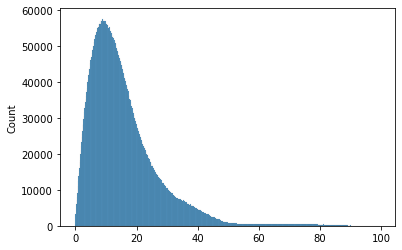

In [22]:
import seaborn as sns

sns.histplot(distance.reshape(-1))

In [23]:
3135*3135*0.1

982822.5

In [24]:
distance[(distance<4.5) & (distance>0)] = 1

In [25]:
distance[(distance>=4.5)&(distance<=6.824)] = 2

In [26]:
Dl = np.sum(distance, 0)
print(np.unique(Dl))
Dn = np.zeros((3135, 3135))
for i in range(3135):
  if Dl[i] > 0:
    Dn[i, i] = Dl[i] ** (-1)
AD = np.dot(distance, Dn)
AD

[ 31729.86313465  31747.31763793  31752.0412256  ... 231446.92745146
 233143.37291925 241189.41061201]


array([[0.00000000e+00, 2.46528144e-05, 2.51489745e-05, ...,
        3.85204091e-04, 3.92189030e-04, 3.91125424e-04],
       [2.66812607e-05, 0.00000000e+00, 2.51489745e-05, ...,
        3.80603101e-04, 3.92451093e-04, 3.94343128e-04],
       [2.66812607e-05, 2.46528144e-05, 0.00000000e+00, ...,
        4.06431315e-04, 4.15403285e-04, 4.17186122e-04],
       ...,
       [6.79218944e-04, 6.20085221e-04, 6.75491667e-04, ...,
        0.00000000e+00, 1.63987497e-05, 3.69115903e-05],
       [6.38103388e-04, 5.89985461e-04, 6.37058726e-04, ...,
        1.51316904e-05, 0.00000000e+00, 1.84557952e-05],
       [5.65444043e-04, 5.26754218e-04, 5.68482856e-04, ...,
        3.02633808e-05, 1.63987497e-05, 0.00000000e+00]])

In [27]:
AD.shape

(3135, 3135)

In [28]:
A = np.zeros((3, 3135, 3135))
for i, hop in enumerate(range(3)):
  A[i][distance == hop] = AD[distance == hop]

In [29]:
data = pd.pivot_table(raw[["dcount", "cfips", "microbusiness_density"]], index = "dcount", columns = "cfips", values = "microbusiness_density")

In [30]:
data

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
dcount,,,,,,,,,,,,,,,,,,,,,
0,3.007682,7.239156,1.073138,1.310777,1.544148,0.926372,0.674981,2.691544,1.486542,1.104277,...,1.150575,5.916088,4.062681,30.183279,6.115724,2.640386,26.433363,4.612016,2.603246,1.548594
1,2.884870,7.290936,0.995794,1.305176,1.575892,0.998556,0.739265,2.703752,1.355156,1.089747,...,1.150575,5.894528,3.888567,31.712736,6.142085,2.858371,26.611856,4.338306,2.683593,1.530794
2,3.055843,7.425439,1.160149,1.254761,1.546415,0.974495,0.713551,2.693764,1.355156,1.084903,...,1.150575,5.881592,3.903076,31.990431,6.181626,2.913635,26.736261,4.420419,2.635385,1.530794
3,2.993233,7.426071,1.000628,1.254761,1.573625,1.022618,1.054256,2.739270,1.362664,1.084903,...,1.200600,5.954897,3.845038,32.776520,6.234348,3.008812,26.920164,4.372520,2.683593,1.601994
4,2.993233,7.470274,1.000628,1.265965,1.555485,1.034649,1.054256,2.729281,1.343894,1.089747,...,1.200600,5.911776,3.845038,32.806427,6.273890,3.088637,26.903938,4.310935,2.635385,1.584194
5,2.969090,7.413655,1.027229,1.253638,1.573217,1.060717,1.060871,2.719628,1.319910,1.079399,...,1.218893,5.901441,3.890260,32.847649,6.353848,3.150922,26.684565,4.367864,2.666882,1.590706
6,2.909326,7.282522,1.022314,1.248041,1.536999,1.036333,1.060871,2.745211,1.331096,1.069675,...,1.269680,5.871155,3.716069,32.246933,6.486774,3.169494,26.738255,4.237172,2.699208,1.519214
7,2.933231,7.309610,1.032144,1.264831,1.541526,1.060717,1.009121,2.756335,1.301268,1.074537,...,1.269680,5.897114,3.527362,32.856171,7.018477,3.237588,26.668457,4.182143,2.699208,1.537087
8,3.000167,7.568799,1.086209,1.270428,1.577744,1.011948,0.996183,2.818625,1.327368,1.059950,...,1.269680,5.979319,3.469299,34.142807,6.965306,3.293302,27.119463,4.195900,2.683045,1.554960


## TimeSeriesSplit

In [31]:
feat = []
label = []

for i in range(10,35):
  X.append(data.values[i-10:i+1])
  Y.append(data.values[i+1:i+5])

In [32]:
np.array(feat)[20:].shape, np.array(label)[20:].shape

((5, 11, 3135), (5, 4, 3135))

In [33]:
feat = np.array(feat)
label = np.array(label)

print(feat.shape)
train = feat[:20]
train_label = label[:20]
valid = feat[20:]
valid_label = label[20:]
print(train.shape, train_label.shape)

(25, 11, 3135)
(20, 11, 3135) (20, 4, 3135)


In [34]:
train = np.array(train).reshape(20, 1,11, 3135)
train_label = np.array(train_label).reshape(20, 4, 3135)

valid = np.array(valid).reshape(5, 1, 11, 3135)
valid_label = np.array(valid_label).reshape(5, 4, 3135)

In [35]:
train_dataset = np.array([(i, j) for (i, j) in zip(train, train_label)])
val_dataset = np.array([(i, j) for (i, j) in zip(valid, valid_label)])

<ipython-input-35-d8a69986a5d8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_dataset = np.array([(i, j) for (i, j) in zip(train, train_label)])
<ipython-input-35-d8a69986a5d8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_dataset = np.array([(i, j) for (i, j) in zip(valid, valid_label)])


In [36]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True)

In [37]:
class SMAPE(nn.Module):
    def __init__(self):
        super(SMAPE, self).__init__()
        

    def forward(self, y_pred, target):
        loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
        return torch.mean(loss)

In [38]:
def train(model, train_loader, optimizer, val_loader, scheduler, device):
  model = model.to(device)
  criterion = SMAPE().to(device)
  best_loss = 1e10
  best_model = None

  hist = {"train" : [],
          "valid" : []}

  for epoch in range(1, 51):
    model.train()
    train_loss = []

    for data, label in tqdm(train_dataloader.dataset):
      data = torch.tensor(data).to(device)
      label = torch.tensor(label).to(device)
      epoch_loss = []
      
      for i in range(4):
        optimizer.zero_grad()

        logit = model(data, A, device)
        logit = logit.view(1, -1)

        data = torch.cat((data[0][1:], logit)).view(1,11, 3135)

        loss = criterion(logit, label[i])
        
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())


      train_loss.append(np.mean(epoch_loss))

    with torch.no_grad():
      valid_loss = []
      for data, label in tqdm(val_loader.dataset):
        model.eval()
        data = torch.tensor(data).to(device)
        label = torch.tensor(label).to(device)
        epoch_loss = []
        for i in range(4):
              
          optimizer.zero_grad()
          
          logit = model(data, A, device)
          logit = logit.view(1, -1)

          data = torch.cat((data[0][1:], logit)).view(1, 11, 3135)

          loss = criterion(logit, label[i])

          epoch_loss.append(loss.item())

        valid_loss.append(np.mean(epoch_loss))

    _valid_loss = np.mean(valid_loss)
    _train_loss = np.mean(train_loss)

    scheduler.step(_valid_loss)

    if _valid_loss < best_loss:
      best_loss = _valid_loss
      best_model = model 

    print("Epoch :", epoch, "train_loss :", _train_loss, "valid_loss :", _valid_loss)
    hist["train"].append(_train_loss)
    hist["valid"].append(_valid_loss)

  print("best loss :", best_loss)
  return best_model, hist

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
import torch
import torch.nn as nn

class Model(nn.Module):

  def __init__(self, in_channels, num_class, A):
    super().__init__()

    self.A = torch.tensor(A, dtype = torch.float32, requires_grad = False)

    spatial_kernel_size = self.A.size(0)
    temporal_kernel_size = 3
    kernel_size = (temporal_kernel_size, spatial_kernel_size)
    self.data_bn = nn.BatchNorm1d(3135)

    self.st_gcn_networks = nn.ModuleList((
        st_gcn(1, 3, kernel_size, 1, residual = False),
        st_gcn(3, 64, kernel_size, 1),
        st_gcn(64, 64, kernel_size, 1),
        st_gcn(64, 64, kernel_size, 1),
        st_gcn(64, 128, kernel_size, 2),
        st_gcn(128, 128, kernel_size, 1),
        st_gcn(128, 128, kernel_size, 1),
        st_gcn(128, 256, kernel_size, 2),
        st_gcn(256, 256, kernel_size, 1),
        st_gcn(256, 256, kernel_size, 1)
    ))

    self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(self.A.shape))
                for i in self.st_gcn_networks
            ])

    self.fcn = nn.Conv2d(256, num_class, kernel_size = 1)

  def forward(self, x, A, device):
    x = torch.tensor(x, dtype = torch.float32)
    x = x.view(1, 1, x.size(1), x.size(2))
    N, C, T, V = x.size()
    x = x.permute(0, 1, 3, 2).contiguous().view(N*C, V, T)
    x = self.data_bn(x)
    x = x.view(N, C, T, V)

    self.A = self.A.to(device)  
    for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
      x = gcn(x, self.A * importance.to(device))

    x = F.avg_pool2d(x, x.size()[2:])
    
    x = self.fcn(x)

    return x.view(-1)

class st_gcn(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size, stride = 1, dropout = 0, residual = True):
    super().__init__()
    padding = ((kernel_size[0] - 1) // 2, 0)
    self.s_kernel_size = kernel_size[1]
    self.gcn = nn.Conv2d(
        in_channels, out_channels * kernel_size[1],
        kernel_size = (1, 1),
        padding = (0, 0),
        stride = (1, 1),
        bias = True
    )

    self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                (kernel_size[0], 1),
                (stride, 1),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )
    
    if not residual:
      self.residual = lambda x : 0

    elif (in_channels == out_channels) and (stride == 1):
      self.residual = lambda x : x

    else :
      self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )
      
    self.relu = nn.ReLU(inplace = True)

  def forward(self, x, A):

    res = self.residual(x)
    x = self.gcn(x)
    n, c, t, v = x.size()
    x = x.view(n, self.s_kernel_size, c // self.s_kernel_size, t, v)
    x = torch.einsum("nkctv, kvw -> nctw", (x, A))
    x = self.tcn(x) + res

    return self.relu(x)

In [41]:
model = Model(1, 3135, A)
model = nn.DataParallel(model, device_ids = [0, 1])

optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

best_model, hist = train(model, train_dataloader, optimizer, val_dataloader, scheduler, device)

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-40-b90fe0543d41>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype = torch.float32)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 1 train_loss : 0.9919915310194345 valid_loss : 1.0842905514987589


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 2 train_loss : 0.9045700640231189 valid_loss : 1.8519870543417667


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 3 train_loss : 0.8968189849393019 valid_loss : 1.8642452883304255


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 4 train_loss : 0.8910506440625662 valid_loss : 1.856506831207409


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 5 train_loss : 0.8866344449835152 valid_loss : 1.8335970311546255


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 6 train_loss : 0.879228320895406 valid_loss : 1.873468962599171


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 7 train_loss : 0.872144850225626 valid_loss : 1.8614743928348694


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 8 train_loss : 0.8660234378607103 valid_loss : 1.8590527942630246


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch : 9 train_loss : 0.8622712317474314 valid_loss : 1.8498790163083743


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 10 train_loss : 0.8596898883709271 valid_loss : 1.853815982763734


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 11 train_loss : 0.8584345384576773 valid_loss : 1.8495936534666844


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.
Epoch : 12 train_loss : 0.8579904194660086 valid_loss : 1.8594833241251236


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 13 train_loss : 0.8592624490503352 valid_loss : 1.877787452849312


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 14 train_loss : 0.8588737415349257 valid_loss : 1.8799006287667317


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 15 train_loss : 0.8589414463013265 valid_loss : 1.8854752722652488


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 16 train_loss : 0.858808666667576 valid_loss : 1.8892035104991298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 17 train_loss : 0.8576214986801869 valid_loss : 1.8900987841740637


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 18 train_loss : 0.8552327502048609 valid_loss : 1.8980504288416928


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 19 train_loss : 0.8536028212111584 valid_loss : 1.900554973471727


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 20 train_loss : 0.8511454768012248 valid_loss : 1.9028675371651755


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 21 train_loss : 0.8503272631380806 valid_loss : 1.8997954670216715


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 22 train_loss : 0.848223331968301 valid_loss : 1.8994053618746052


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.
Epoch : 23 train_loss : 0.8459617056681787 valid_loss : 1.8933427392514486


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 24 train_loss : 0.8474794463992362 valid_loss : 1.9029700154185487


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 25 train_loss : 0.846930591226676 valid_loss : 1.906563607865575


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 26 train_loss : 0.8463671893047631 valid_loss : 1.9097762340222695


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 27 train_loss : 0.8451565997018692 valid_loss : 1.9095968708881401


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 28 train_loss : 0.8443289900225931 valid_loss : 1.9160662241511197


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 29 train_loss : 0.8412964535581932 valid_loss : 1.9131123678859154


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 30 train_loss : 0.8380967157277073 valid_loss : 1.9214051573922029


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 31 train_loss : 0.8326965682599937 valid_loss : 1.9150479281331587


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 32 train_loss : 0.8304478090509967 valid_loss : 1.9073696387590655


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 6.2500e-05.
Epoch : 33 train_loss : 0.8270068368113748 valid_loss : 1.9097927805248616


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 34 train_loss : 0.825788459766232 valid_loss : 1.9222867645393962


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 35 train_loss : 0.8233277800062246 valid_loss : 1.9199114097219365


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 36 train_loss : 0.8214486430946211 valid_loss : 1.9169050748680114


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 3.1250e-05.
Epoch : 37 train_loss : 0.8182666552551131 valid_loss : 1.9194558471227015


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 38 train_loss : 0.8161634130402591 valid_loss : 1.9230329140295441


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 39 train_loss : 0.8116546346119675 valid_loss : 1.9263553896454007


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 40 train_loss : 0.8072423401465258 valid_loss : 1.9265734578067373


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 41 train_loss : 0.8021338088997009 valid_loss : 1.9266078170924046


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 42 train_loss : 0.7969543704653093 valid_loss : 1.9264625680940184


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00043: reducing learning rate of group 0 to 1.5625e-05.
Epoch : 43 train_loss : 0.792144670358733 valid_loss : 1.925875708867401


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 44 train_loss : 0.7893034461186377 valid_loss : 1.9261749471466598


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 45 train_loss : 0.7865785654393059 valid_loss : 1.927912845842491


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 46 train_loss : 0.7843742133673284 valid_loss : 1.9303870307297804


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 47 train_loss : 0.7828556465249263 valid_loss : 1.931955668879174


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 48 train_loss : 0.7808501946028849 valid_loss : 1.9328265270936327


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 49 train_loss : 0.7784257653516146 valid_loss : 1.9342321875773831


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 50 train_loss : 0.7763269392211247 valid_loss : 1.9345259942927604
best loss : 1.0842905514987589


In [47]:
test_data = [data.values[-11:]]
test_data = np.array(test_data)
test_data.shape

(1, 11, 3135)

In [50]:
def inference(model, test_data):
  model = model.to(device)
  with torch.no_grad():
    model.eval()
    test_data = torch.tensor(test_data).to(device)
    pred = torch.zeros((4, 3135))
    for i in range(4):
          
      optimizer.zero_grad()
      
      logit = model(test_data, A, device)
      logit = logit.view(1, -1)
      pred[i, :] = logit
      test_data = torch.cat((test_data[0][1:], logit)).view(1, 11, 3135)

  return pred

In [51]:
pred = inference(best_model, test_data)

<ipython-input-40-b90fe0543d41>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype = torch.float32)


In [69]:
pred

tensor([[ 1.4356e+02, -3.5972e+01,  6.9055e+01,  ..., -4.1917e+01,
          1.6043e+02,  9.7549e+01],
        [ 3.5915e+04, -9.0887e+03,  1.7538e+04,  ..., -1.0061e+04,
          3.9926e+04,  2.4005e+04],
        [ 9.1511e+06, -2.3153e+06,  4.4695e+06,  ..., -2.5640e+06,
          1.0172e+07,  6.1159e+06],
        [ 2.3317e+09, -5.8993e+08,  1.1388e+09,  ..., -6.5332e+08,
          2.5919e+09,  1.5584e+09]])

In [53]:
submit = pd.read_csv("sample_submission.csv")
submit

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671
...,...,...
25075,56037_2023-06-01,3.817671
25076,56039_2023-06-01,3.817671
25077,56041_2023-06-01,3.817671
25078,56043_2023-06-01,3.817671


In [77]:
submit["microbusiness_density"][:12540] = np.array(pred.clip(0,)).reshape(12540,)

In [79]:
submit.to_csv("GCN.csv", index = False)